## 7 - SARIMA Models

### 7.1 Seasonal ARIMA Models
**Definition**: 

- The SARIMA model combines non-seasonal ARIMA components (AutoRegressive, Integrated, Moving Average) with seasonal components.

- Notation: $(p,d,q)\times (P,D,Q)_s$
    - $p,d,q$: Non-seasonal AR, differencing, and MA orders.

    - $P,D,Q$: Seasonal AR, differencing, and MA orders.

    - $s$: Seasonal period (e.g., $s=12$ for monthly data with yearly seasonality).

- Mathematical representation:
$$\Phi_P(B^s)\phi_p(B)(1 - B^s)^D(1 - B)^d y_t = \Theta_Q(B^s)\theta_q(B) \epsilon_t$$
- Components:

    - $\Phi_P(B^s)$: Seasonal AR

    - $\phi_p(B)$: Ordinary AR

    - $(1 - B^s)^D$: Seasonal differencing

    - $(1 - B)^d$: Ordinary differencing

    - $\Theta_Q(B^s)$: Seasonal MA
    
    - $\theta_q(B)$: Ordinary MA

https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/

### 7.2 Seasonal Components Identification
1. Seasonal Differencing ($D$)

- If your time series shows a clear seasonal pattern (e.g., a yearly cycle in monthly data), you might need to apply seasonal differencing.

- Seasonal differencing means subtracting the value from the same season in the previous period: $y_t^{'}=y_t-y_{t-s}$.

- If the ACF plot shows a slow decay or periodicity, this indicates non-stationarity and suggests the need for seasonal differencing.

2. Identify $D$:

- Look at the ACF plot before seasonal differencing. If there is a significant spike at lag $s$ and its multiples ($2s,3s,\dots$), it indicates the presence of seasonality. After seasonal differencing, these spikes should diminish if differencing was needed.

- Example: For monthly data with yearly seasonality ($s=12$), check for spikes at lags 12, 24, 36, etc.
Seasonal AR ($P$) and MA ($Q$)

3. Seasonal Autoregressive ($P$):

- Seasonal AR terms ($P$) are identified by examining the PACF plot. Significant spikes at lags that are multiples of 
$s$ (e.g., 12, 24, 36 for monthly data with yearly seasonality) in the PACF plot suggest the order of the seasonal AR component.

- Example: If there is a significant spike at lag 12 in the PACF plot, it suggests $P=1$.

4. Seasonal Moving Average ($Q$):

- Seasonal MA terms ($Q$) are identified by examining the ACF plot. Significant spikes at lags that are multiples of $s$ in the ACF plot suggest the order of the seasonal MA component.

- Example: If there is a significant spike at lag 12 in the ACF plot, it suggests $Q=1$.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [9]:
# Generate a synthetic time series (for the purpose of this class)
np.random.seed(42)
n = 500
t = np.arange(n)
seasonal = 10 * np.sin(2 * np.pi * t / 12)
ar = np.zeros(n)
ma = np.zeros(n)
e = np.random.normal(size=n)
ar[0] = e[0]
for i in range(1, n):
    ar[i] = 0.6 * ar[i-1] + e[i]
ma[0] = e[0]
for i in range(1, n):
    ma[i] = e[i] + 0.5 * e[i-1]
trend = 0.01 * t
series = seasonal + ar + ma + trend + np.random.normal(size=n)

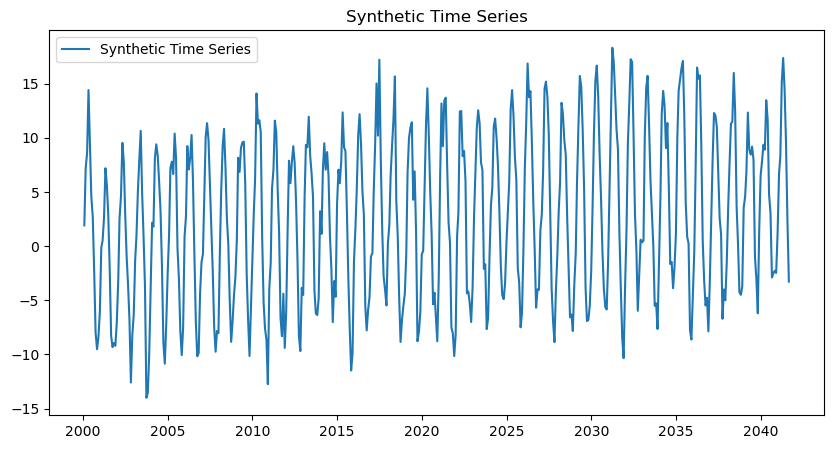

In [10]:
# Create a DataFrame
df = pd.DataFrame({'value': series})
df.index = pd.date_range(start='2000-01-01', periods=n, freq='M')

# Plot the synthetic time series
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['value'], label='Synthetic Time Series')
plt.title('Synthetic Time Series')
plt.legend()
plt.show()


In [13]:
# Make the time series stationary
diff_df = df.diff().dropna()

# Check stationarity
adf = adfuller(diff_df.dropna())
print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])
for key, value in adf[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')


ADF Statistic: -14.677337
p-value: 0.000000
Critical Values:
   1%, -3.443849184997939
Critical Values:
   5%, -2.8674931065091105
Critical Values:
   10%, -2.569940776113236


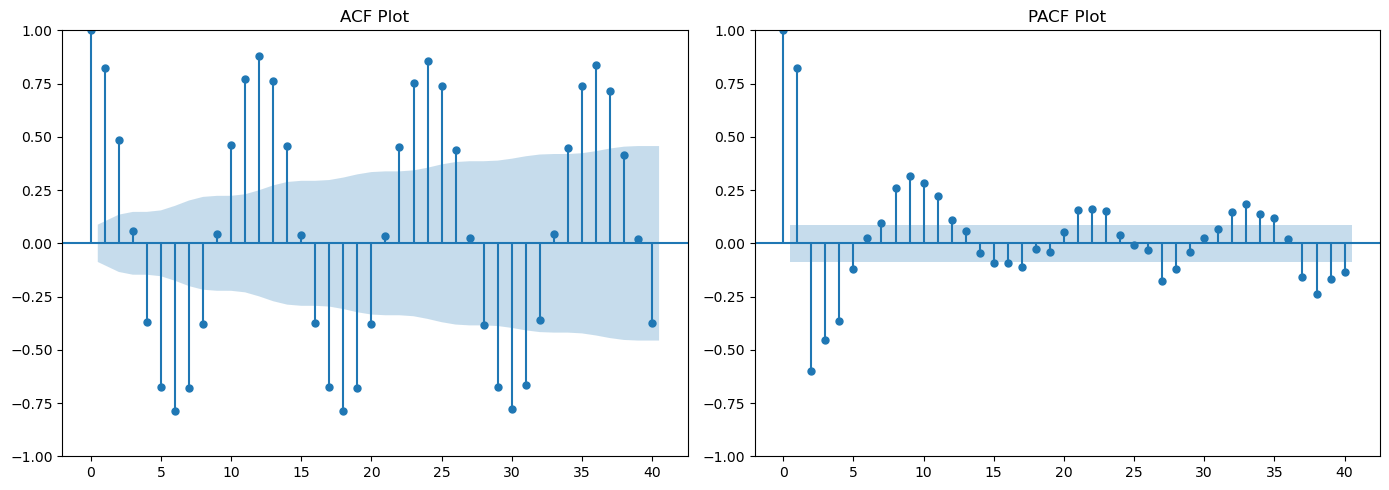

In [16]:
# ACF and PACF plots
plt.figure(figsize=(14, 5))
plt.subplot(121)
plot_acf(df['value'], lags=40, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(df['value'], lags=40, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65802D+00    |proj g|=  2.71596D-01

At iterate    5    f=  1.51452D+00    |proj g|=  3.91335D-02

At iterate   10    f=  1.48974D+00    |proj g|=  1.59702D-02

At iterate   15    f=  1.48462D+00    |proj g|=  2.97190D-02

At iterate   20    f=  1.48212D+00    |proj g|=  9.05856D-03

At iterate   25    f=  1.48192D+00    |proj g|=  6.51081D-04

At iterate   30    f=  1.48190D+00    |proj g|=  4.72988D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

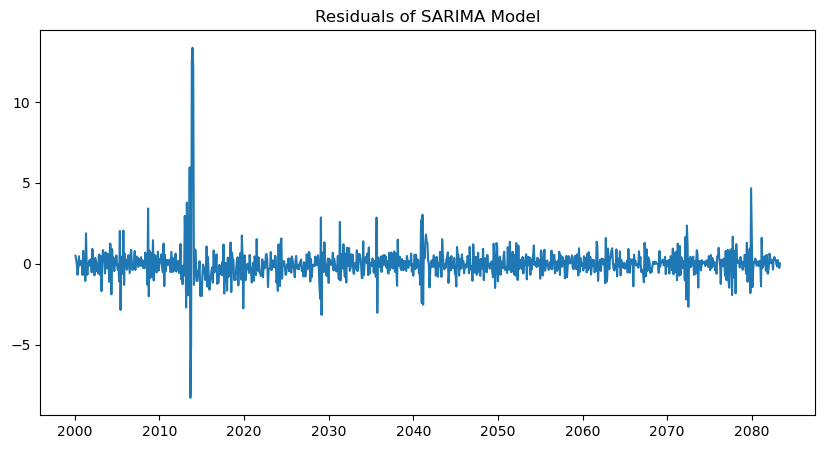

In [95]:
# Fit SARIMA model
sarima_model = SARIMAX(df, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
print(sarima_model.summary())

# Model diagnostics
residuals = sarima_model.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals of SARIMA Model')
plt.show()

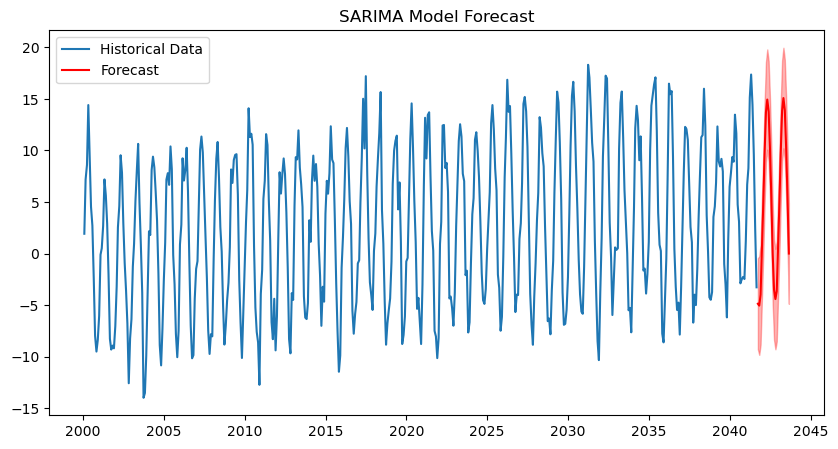

In [20]:
# Forecasting
forecast = sarima_model.get_forecast(steps=24)
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=30), periods=24, freq='M')
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10, 5))
plt.plot(df.index, df, label='Historical Data')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
# Plot confidence interval
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.3)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()


### 7.3 Ljung-Box Test

- Ljung-Box Test is used to check the autocorrelation in the residuals.

- Null Hypothesis (H0): There is no autocorrelation in the residuals up to the specified lag.

- Alternative Hypothesis (H1): There is autocorrelation in the residuals up to the specified lag.

**Key Output of the Ljung-Box Test**

- Test Statistic: A measure of the amount of autocorrelation in the residuals.

- p-value: The probability of observing the test statistic under the null hypothesis.

In [96]:
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_results = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print(ljung_box_results)

      lb_stat  lb_pvalue
10  11.542510   0.316840
20  18.534393   0.552249
30  20.871434   0.891865


Since the p-values are all greater than 0.05, there is no significant autocorrelation in the residuals up to lag 10, 20 and 30.

## 8 - ARCH Models

### 8.1 Volatility Clustering
Volatility Clustering:

- Some time series have variance changing consistently over time. In the financial domain, this is called "volatility".

- Periods of high volatility tend to be followed by high volatility, and periods of low volatility tend to be followed by low volatility. Example: Financial time series like stock returns often show volatility clustering.

- Correlaated variance can be modeled using autoregressive models.

### 8.2  Autoregressive Conditional Heteroskedasticity (ARCH) Models

- ARCH models the change in variance over time in a time series. It models the variance at time $t$ as a function of the residual errors from a mean process. 

- Put otherwise, the model assumes that the variance of the current error term (volatility) is a function of the past error terms.

- Notation: ARCH (q). q: Order of the ARCH model (number of lagged squared residuals included).

- Mathematical representation: 
$$\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \ldots + \alpha_q \epsilon_{t-q}^2$$

where $\sigma_t^2$ is the conditional variance and $\epsilon_t$ is the residual error at time $t$.

In [21]:
# pip install arch --default-timeout=100
# Do this if needed

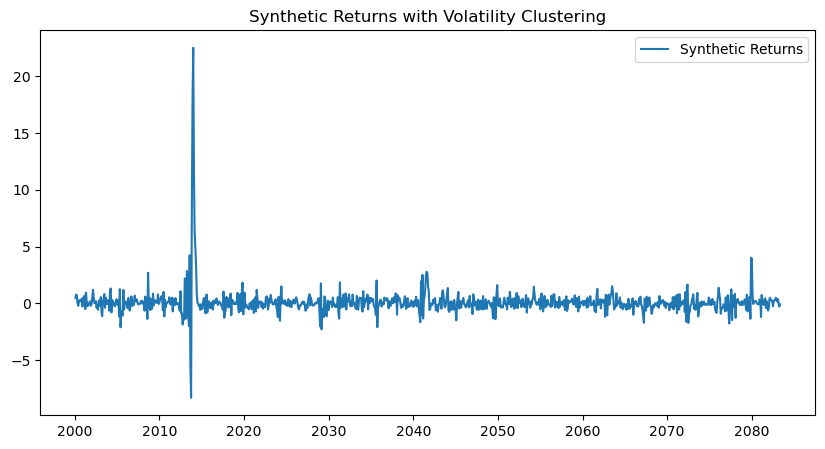

In [79]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Generate synthetic data
np.random.seed(42)
n = 1000
e = np.random.normal(size=n)
sigma = np.zeros(n)
alpha0 = 0.1
alpha1 = 0.85

for t in range(1, n):
    sigma[t] = np.sqrt(alpha0 + alpha1 * e[t-1]**2)
    e[t] = sigma[t] * np.random.normal()

df = pd.DataFrame({'returns': e})
df.index = pd.date_range(start='2000-01-01', periods=n, freq='M')

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['returns'], label='Synthetic Returns')
plt.title('Synthetic Returns with Volatility Clustering')
plt.legend()
plt.show()

**Steps to Check Residuals**

1. Raw Residuals: Examine the ACF of the raw residuals to identify any autocorrelation structure.

2. Squared Residuals: Examine the ACF of the squared residuals to check for ARCH effects.

**Identification of ARCH Order Using ACF and PACF Plots**

To identify the order of an ARCH model:

1. ACF of Squared Residuals: If you observe significant spikes at certain lags, this suggests the presence of ARCH effects.

2. PACF of Squared Residuals: The number of significant spikes in the PACF plot of the squared residuals can suggest the order of the ARCH model.

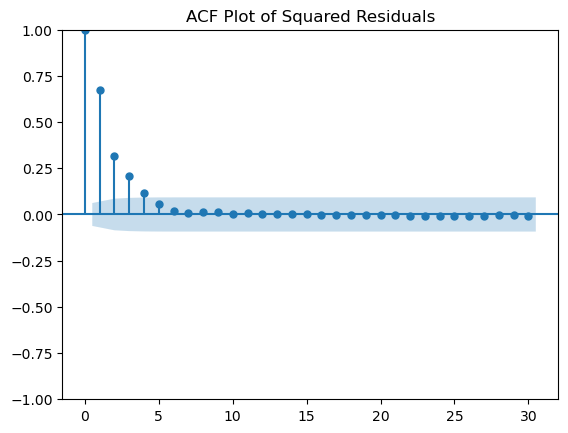

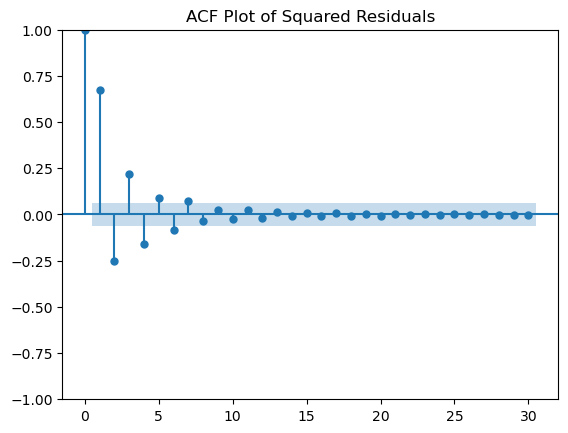

In [93]:
# Plot ACF and PACF of squared residuals
squared_residuals = df['returns'] **2


plot_acf(squared_residuals, lags=30, ax=plt.gca())
plt.title('ACF Plot of Squared Residuals')
plt.show()

plot_pacf(squared_residuals, lags=30, ax=plt.gca())
plt.title('ACF Plot of Squared Residuals')
plt.show()

The ACF plot of the squared residuals will show significant autocorrelation if ARCH effects are present.

In [94]:
# Fit an ARCH model

from arch import arch_model

model = arch_model(df['returns'], vol='ARCH', p=5)
arch_fit = model.fit()
print(arch_fit.summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 212152.16834785228
Iteration:      2,   Func. Count:     22,   Neg. LLF: 297840.42103510327
Iteration:      3,   Func. Count:     31,   Neg. LLF: 68403.6053097838
Iteration:      4,   Func. Count:     40,   Neg. LLF: 996.4464252796495
Iteration:      5,   Func. Count:     49,   Neg. LLF: 305927.77286019584
Iteration:      6,   Func. Count:     58,   Neg. LLF: 820.280494060819
Iteration:      7,   Func. Count:     67,   Neg. LLF: 810.4016619668059
Iteration:      8,   Func. Count:     76,   Neg. LLF: 729.9685034664585
Iteration:      9,   Func. Count:     84,   Neg. LLF: 777.0218958164
Iteration:     10,   Func. Count:     94,   Neg. LLF: 740.7616791352644
Iteration:     11,   Func. Count:    103,   Neg. LLF: 729.2495745044889
Iteration:     12,   Func. Count:    112,   Neg. LLF: 727.0050040225309
Iteration:     13,   Func. Count:    120,   Neg. LLF: 726.8178572724516
Iteration:     14,   Func. Count:    128,   Neg. LLF: 4975.3643431

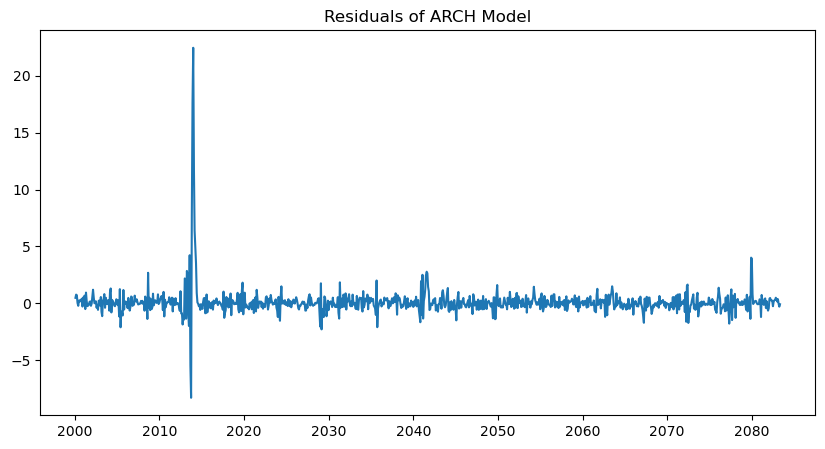

In [82]:
# Model diagnostics - Residual analysis
# Check the residuals of the fitted model to ensure there are no remaining ARCH effects (ideally).

residuals = arch_fit.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals of ARCH Model')
plt.show()

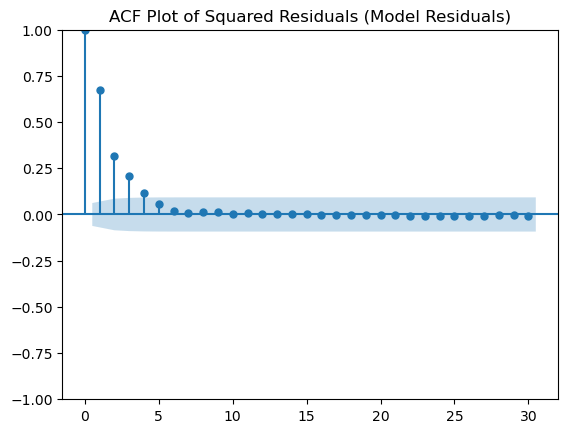

In [84]:
# Plot ACF of squared residuals
# The ACF plot of the squared residuals of the fitted model should show no significant autocorrelation.

new_squared_residuals = residuals**2

plot_acf(new_squared_residuals, lags=30, ax=plt.gca())
plt.title('ACF Plot of Squared Residuals (Model Residuals)')
plt.show()

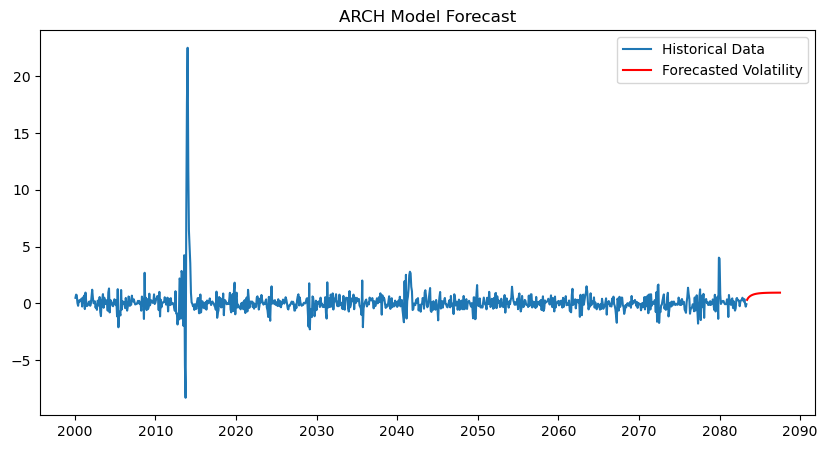

In [56]:
# Forecast with ARCH

forecast_horizon = 50
forecast = arch_fit.forecast(horizon=forecast_horizon)
forecast_variance = forecast.variance[-1:]
last_date = df.index[-1]
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='M')

plt.figure(figsize=(10, 5))
plt.plot(df.index, df['returns'], label='Historical Data')
plt.plot(forecast_index, np.sqrt(forecast_variance.iloc[0]), label='Forecasted Volatility', color='red')
plt.title('ARCH Model Forecast')
plt.legend()
plt.show()

**Summary**:

1. ARCH Models: Capture time-varying volatility.

2. Identification: Use ACF and PACF plots of squared residuals.

3. Estimation: Fit the ARCH model using the arch package in Python.

4. Diagnostics: Check residuals to ensure no remaining ARCH effects.

5. Forecasting: Forecast future volatility using the fitted ARCH model.

## Exercises


1. Fitting a SARIMA Model to a Real-World Dataset.

Steps:

- Load and visualize the dataset.

- Identify the orders (p, d, q) and seasonal orders (P, D, Q, s) using ACF and PACF plots.

- Fit a SARIMA model to the data.

- Evaluate the model using appropriate metrics (e.g., AIC, BIC).

- Forecast future values and visualize the forecasted results.

2. Perform diagnostic checks on the fitted SARIMA model.

Steps:

- Plot the residuals of the fitted SARIMA model.

- Plot the ACF and PACF of the residuals.

- Perform the Ljung-Box test to check for autocorrelation in the residuals.